# Basic Hands-on 1: Hand-written image classification with the MNIST data set

This session introduces the use of neural networks in a famous classification task: the image classification of hand-written digits from the MNIST data set.

The MNIST dataset is a widely used benchmark in the field of machine learning and computer vision. MNIST serves as a standard dataset for evaluating classification algorithms and is commonly used for training and testing various machine learning models, particularly in the context of deep learning. Its simplicity and accessibility make it a popular starting point for those learning about image classification.

### What we will learn:

1. loading a  data set
2. how to build simple neural network
3. training a model
4. evaluation of the model
5. how to make a prediction

In this tutorial we will use a simple python environment with the package pytorch. There are other options to implement networks, but will not be discussed in this workshop.


In [3]:
# load necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device (GPU if available, mps on Mac, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

### 1. Loading the data set

The MNIST data set consists of 70,000 grayscale images of handwritten digits (0-9), with each image being 28x28 pixels in size. The dataset is divided into 60,000 training images and 10,000 test images. A machine learning model (supervised) needs to be trained on known, labeled data to predict class categories. The test set is used to classify and predict the class category of unknown images. Comparing the predictions with the provide class label can tell is how well the model can predicted unknown data from the same dataset.

In this example, training and test set are loaded separately. Both are converted into tensors to be readable with pytorch and each pixel entry is normalized.

Note: normalization of the data is not necessary, but can fasten the training process because the data is then within the same defined range.


In [4]:
# Transformations - save images as tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# download training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:12<00:00, 774009.83it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 146047.97it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1388603.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4073236.85it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The data is loaded in batches. They allow parallel training of the networks later on, and loading data into memory more efficiently. Typical choices are:

- Small batch (e.g., 16, 32) → More noise, better generalization, slower convergence.
- Medium batch (e.g., 64, 128) → Balanced between speed and stability.
- Large batch (e.g., 256, 512, 1024) → Faster but requires more memory, may overfit.

In [5]:
# check size of data set

print(len(train_dataset))
print(train_dataset[0])

60000
(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0

How the data looks like:

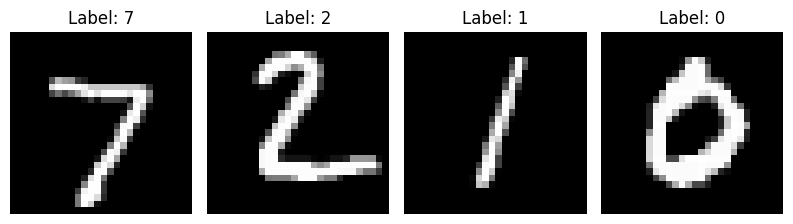

In [7]:
# Get a batch of images and labels
images, labels = next(iter(test_loader))

# Plot the first 4 images
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### 2. Build a simple model

The structure of adding layers / building block of networkds are always the same.

In `__init__`  the network is initialized. Layers and their sizes can be added:

* `nn.Linear(input_features, output_features)` class in PyTorch is used to create a fully connected (dense) layer in a neural network.
   <br> The size of output features must match the number of class labels.

* here a linear transformation is performed: $y=xW^T +b$ where
  <br> $y$ is the output, <br> $x$ is the input, <br> $W$ is the weight matrix (learned parameters), <br> $b$ is the bias vector (also learned parameters).

* other options are: `nn.Conv1d`, `nn.Conv2d`, `nn.RNN`, `nn.MaxPool2d`, `nn.Sigmoid`, `nn.Dropout` etc. (See Basics II)

* hidden layers use more dimensions and the dimension of the final output is reduced in the last layer.

`forward()` defines what happens during the forward pass through the network. The input tensor is propagated through all layers.
* flatten image: dense layers require a 1D input, our dataset is 2D
* activation functions of each , other options: `torch.sigmoid`, `torch.tanh` etc.
* return output layer

Note: Without the activation functions, any concatenation of linear layers is the same as just one layer.



In [8]:
class SimpleDNN(nn.Module):
    def __init__(self):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer to hidden layer
        self.fc2 = nn.Linear(128, 64)        # Hidden layer to hidden layer
        self.fc3 = nn.Linear(64, 10)         # Hidden layer to output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # Activation function 
        x = torch.relu(self.fc2(x))  # Activation function
        x = self.fc3(x)               # Output layer
        return x

model = SimpleDNN().to(device)
print(model)

SimpleDNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


### 3. Train the model

Here we use Cross Entropy as loss function and the **Adam optimizer**. **Optimizer**, **learning rate**, **loss function**, and **number of epochs** can be adapted.

important settings:
<br> `optimizer.zero_grad()`: set gradients to zero because gradients are accumulated by default in pytorch
<br> `outputs = model(images)`: activations for each layer are calculated
<br> `loss.backward() `: computation of loss gradients. Weights are adjusted to minimize loss for next interactions.



In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
def train(model, train_loader, criterion, optimizer, epochs=5):
    model = model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0 # set current loss to 0
        for images, labels in train_loader: #iterate over batches of training images
            images, labels = images.to(device), labels.to(device) # move images and labels to correct device
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass of input data
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item() #accumulate loss of current epoch
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

train(model, train_loader, criterion, optimizer, epochs=5)


Epoch 1, Loss: 0.39164497835565604
Epoch 2, Loss: 0.1939763755841391
Epoch 3, Loss: 0.1436274074681246
Epoch 4, Loss: 0.11430924195847882
Epoch 5, Loss: 0.09971098041262176



The loss decreases with the training epochs. Let's evaluate the model in more detail.

### 4. Evaluate the  model

The model is evaluated on the test set to ensure unbiased model evaluation and prevent overfitting, allowing for accurate assessments of the model's ability to generalize to unseen data.

In some cases, a third set, the validation set, is required for independent model evaluation. It is used for optimizing hyperparameters on unseen data. The final performance is then tested on the test set.



 Note the following:

* `model.eval()`: evaluation of model
* `torch.no_grad()`: disable gradient computation to save memory usage & speed up computation (only needed for training)


In [10]:
def evaluate(model, test_loader):
    model = model.to(device)
    model.eval()
    correct = 0 #keep track of correct predictions
    total = 0 # total number
    with torch.no_grad():
        for images, labels in test_loader: # loop over all data in test set
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # Forward pass of input data
            _, predicted = torch.max(outputs.data, 1) # find index of maximum value in outputs
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

evaluate(model, test_loader)


Accuracy: 96.38%


### 5. Make a prediction


Here we make a prediction of an unknown image with a trained model.

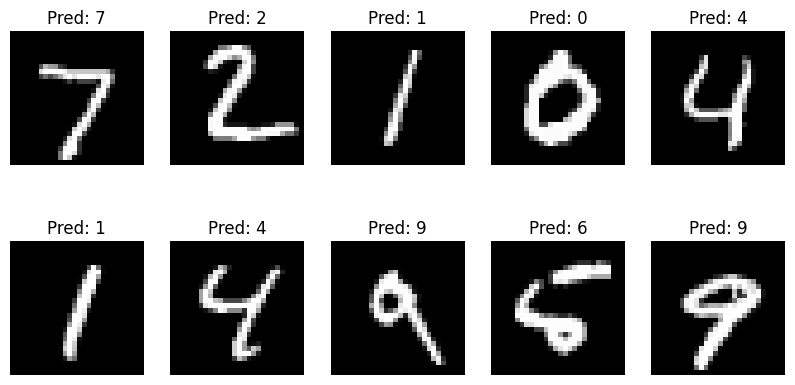

In [11]:
def plot_predictions(model, data_loader):
    model = model.to(device)
    model.eval()
    
    # Get a batch of images and labels
    images, labels = next(iter(data_loader))
    
    # Move images to the same device as the model
    images = images.to(device)  # Ensure images are on the same device (GPU/CPU)
    
    # Forward pass through the model
    outputs = model(images)
    
    # Get the predicted class for each image
    _, predicted = torch.max(outputs.data, 1)  # Max value index -> class
    
    # Move images and labels back to CPU for plotting
    images = images.cpu()  # Move images back to CPU for matplotlib
    predicted = predicted.cpu()  # Also move predictions to CPU for displaying

    # Plot the first 10 images and their predictions
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')  # Convert to NumPy after moving to CPU
        plt.title(f'Pred: {predicted[i].item()}')
        plt.axis('off')
    plt.show()

# Call the function to plot predictions
plot_predictions(model, test_loader)

Some digits do look very similar in handwriting, which leads to potential misclassifications.

After understanding building blocks of a neural network, it is now your turn:

## Exercise 1: Modify the Neural Network Architecture

Your task is to adapt and optimize a neural network for classifying handwritten digits using the MNIST dataset. You will be required to make modifications to the existing model architecture, training process, and evaluation techniques to improve performance.

a) Add an additional hidden layer to the existing model. Experiment with different numbers of neurons in the new layer (e.g., 128, 256) and see how it affects performance.

b)  Introduce an activation function other than ReLU for one of the hidden layers (e.g., Leaky ReLU, Tanh). Compare it to the original ReLu in terms of training performance.

Note: Ensure you have the MNIST dataset loaded and a basic neural network model defined. You can start with a simple feedforward neural network architecture.



In [20]:
#solution a)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Input layer (784) -> First hidden layer (256) -> Second hidden layer (128) -> Output layer (10)
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer to hidden layer
        self.fc2 = nn.Linear(128,256)      # Hidden layer to hidden layer
        self.fc3 = nn.Linear(256,64)       # Hidden layer to hidden layer
        self.fc4 = nn.Linear(64, 10)       # hideen layer to output

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = torch.relu(self.fc1(x))  # First layer
        x = torch.relu(self.fc2(x))  # Second layer
        x = torch.relu(self.fc3(x))  # Third layer
        x = self.fc4(x)              # Output layer
        return x


In [21]:
model = SimpleNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, epochs=5):
    model = model.to(device)
    model.train()
    loss_values = []  # List to store loss values
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()
       
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)  # Append average loss for the epoch
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

# Train the model
train(model, train_loader, criterion, optimizer, epochs=5)


Epoch 1, Loss: 0.3760402344230777
Epoch 2, Loss: 0.1613138197406904
Epoch 3, Loss: 0.12248500909801247
Epoch 4, Loss: 0.10089112605913472
Epoch 5, Loss: 0.08571616748619929


we need to evaluate the model to compare it with the previous one:

In [22]:
def evaluate(model, test_loader):
    model = model.to(device)
    model.eval()
    correct = 0 #keep track of correct predictions
    total = 0 # total number
    with torch.no_grad():
        for images, labels in test_loader: # loop over all data in test set
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # Forward pass of input data
            _, predicted = torch.max(outputs.data, 1) # find index of maximum value in outputs
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

evaluate(model, test_loader)

Accuracy: 97.11%


The accuracy improved a little.

In [26]:
# solution b)

class SimpleNNWithTanh(nn.Module):
    def __init__(self):
        super(SimpleNNWithTanh, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer to hidden layer
        self.fc2 = nn.Linear(128, 64)       # Hidden layer to hidden layer
        self.fc3 = nn.Linear(64, 10)        # Hidden layer to output
        self.relu = nn.ReLU()             # Activation function for the first layer - we can add it to tghe class
        self.tanh = nn.Tanh()             # Tanh activation function for the second layer

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = self.relu(self.fc1(x))  # First layer with ReLU
        x = self.tanh(self.fc2(x))   # Second layer with Tanh
        x = self.fc3(x)               # Output layer
        return x
    
model_tanh = SimpleNNWithTanh().to(device)


criterion = nn.CrossEntropyLoss()
optimizer_tanh = optim.Adam(model_tanh.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, epochs=5):
    model = model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

# Train the Tanh model
train(model_tanh, train_loader, criterion, optimizer_tanh, epochs=5)


evaluate(model, test_loader)

Epoch 1, Loss: 0.37012431922275374
Epoch 2, Loss: 0.16684398474469622
Epoch 3, Loss: 0.1242355167516259
Epoch 4, Loss: 0.10075603605611429
Epoch 5, Loss: 0.08510549587787374
Accuracy: 97.11%


### Exercise 2: Evaluate the model performance

After training, evaluate your model on the test dataset and report the accuracy.

Generate a confusion matrix to visualize the model's performance on each digit class.
Plot some example predictions alongside their true labels and analyze any misclassifications.

(Subtask: Discuss possible reasons for misclassifications and suggest potential improvements. )

In [27]:
# Define function to evaluate and report accuracy
def evaluate_and_report(model, test_loader):
    model = model.to(device)
    model.eval()
    num_classes = 10  # MNIST has 10 digit classes (0-9)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)  # Initialize empty confusion matrix
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update confusion matrix
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

    # Normalize the confusion matrix along rows (true labels)
    cm_normalized = confusion_matrix.astype(float) / confusion_matrix.sum(axis=1, keepdims=True)

    # Handle NaN values which can occur if a row sum is zero (no true labels for a class)
    cm_normalized = np.nan_to_num(cm_normalized)

    # Plot the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    # Add labels to the plot
    threshold = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, f'{cm_normalized[i, j]:.2f}', 
                 horizontalalignment="center", 
                 color="white" if cm_normalized[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    return accuracy, confusion_matrix

In [28]:
def plot_example_predictions(model, data_loader, num_examples=10):
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(data_loader))
    
    # Move images and labels to the same device as the model
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass through the model
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)  # Get predicted classes

    # Move images and labels back to CPU for plotting
    images = images.cpu()  # Move images to CPU
    labels = labels.cpu()  # Move labels to CPU
    predicted = predicted.cpu()  # Move predictions to CPU

    # Plot the first 'num_examples' images with their predicted and true labels
    plt.figure(figsize=(12, 6))
    for i in range(num_examples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')  # Convert to NumPy after moving to CPU
        plt.title(f'True: {labels[i].item()}\nPred: {predicted[i].item()}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Identify and print misclassified examples
    misclassified = (predicted != labels)
    if misclassified.sum() > 0:
        print(f'Misclassified examples: {misclassified.sum()}/{num_examples}')
        
        # Get misclassified images and their labels
        misclass_images = images[misclassified]
        misclass_labels = labels[misclassified]
        misclass_preds = predicted[misclassified]
        
        # Move misclassified examples back to CPU for plotting
        misclass_images = misclass_images.cpu()
        misclass_labels = misclass_labels.cpu()
        misclass_preds = misclass_preds.cpu()
        
        # Plot misclassified examples
        plt.figure(figsize=(12, 6))
        for i in range(min(10, misclassified.sum())):
            plt.subplot(2, 5, i + 1)
            plt.imshow(misclass_images[i].numpy().squeeze(), cmap='gray')  # Convert to NumPy after moving to CPU
            plt.title(f'True: {misclass_labels[i].item()}\nPred: {misclass_preds[i].item()}')
            plt.axis('off')
        plt.suptitle('Misclassified Examples')
        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified examples found.")

Accuracy: 97.11%


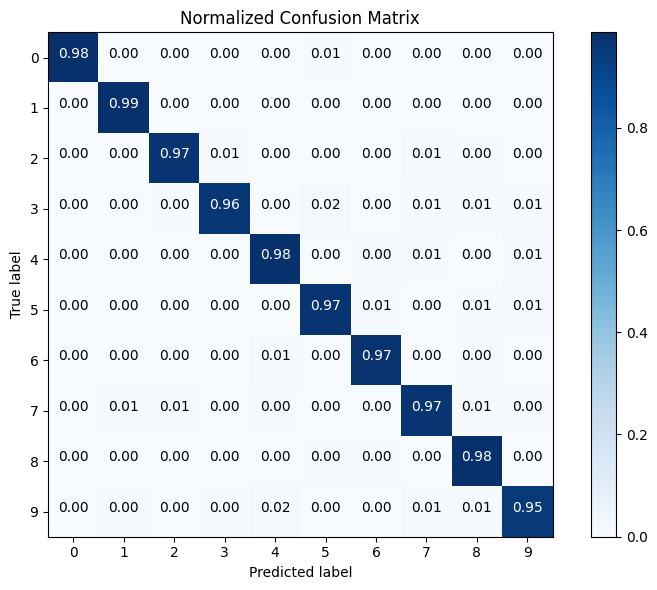

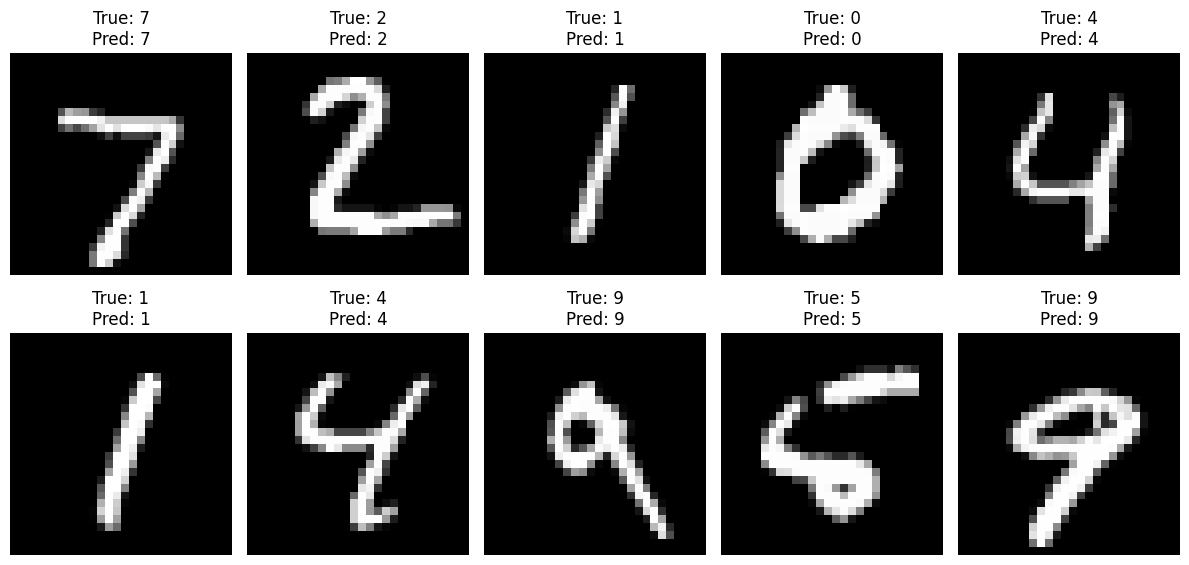

No misclassified examples found.


In [29]:
accuracy, cm = evaluate_and_report(model, test_loader)
plot_example_predictions(model, test_loader)

#### Potential reasons for misclassification:

* Ambiguity in Handwritten Digits:
<br> Handwritten digits can have significant variations depending on the individual style, which can cause ambiguity.
* Insufficient Model Capacity:
<br> The current model (SimpleDNN) is a relatively small fully-connected network with only two hidden layers. This architecture may not have enough capacity to learn complex patterns in the dataset.
More sophisticated architectures like Convolutional Neural Networks (CNNs) are better suited for image data as they can capture spatial hierarchies in the image pixels (e.g., edges, textures, and shapes) more effectively.
* Overfitting to the Training Data:
<br> If the model is overfitting, it means that it performs well on the training data but struggles to generalize to unseen test data. Overfitting can occur due to:
Lack of regularization techniques (e.g., dropout or batch normalization).
Using a fixed and small training dataset without any augmentation, making it harder for the model to generalize to new inputs.
* Underfitting Due to Limited Training:
<br> If the model is not trained long enough or the learning rate is too high, it may not converge to an optimal solution, leading to underfitting.
This causes the model to have high error rates on both the training and test sets as it hasn't fully learned the underlying patterns in the data.
* Noise in the Dataset:
<br> Although the MNIST dataset is generally clean, there can still be mislabeled or noisy samples.
* Unbalanced Data Representation:
<br> While MNIST is fairly balanced, the presence of a few minority classes in other datasets can lead to a bias where the model predicts the majority class more often, resulting in misclassifications.

### Exercise 3: Optimize the Training Process

Experiment with different optimizers (e.g., Adam, SGD, RMSprop).

Compare the training time and final accuracy for each optimizer and provide a brief analysis of your findings.



Training with Adam Optimizer


Epoch 1, Loss: 0.3873318170131778
Epoch 2, Loss: 0.1810207976890144
Epoch 3, Loss: 0.13461999684524562
Epoch 4, Loss: 0.10821004835134154
Epoch 5, Loss: 0.0943864654364394
Accuracy: 96.86%


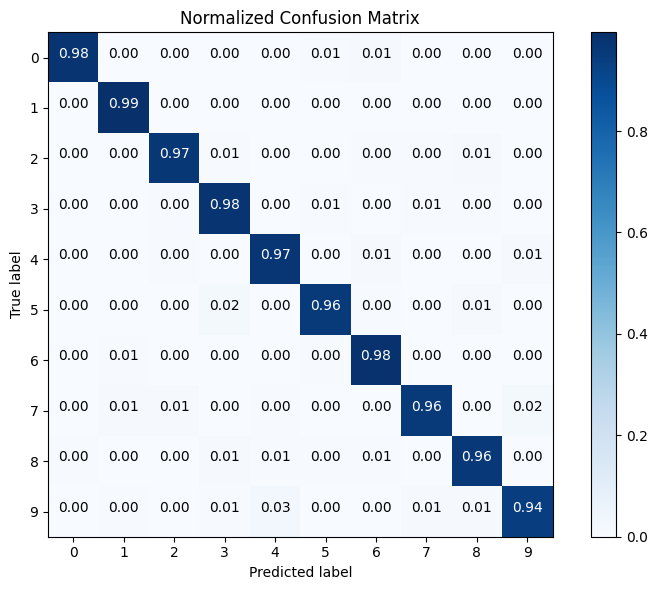


Training with SGD Optimizer
Epoch 1, Loss: 2.2390322217554934
Epoch 2, Loss: 2.0406275091649118
Epoch 3, Loss: 1.6349635129290094
Epoch 4, Loss: 1.156820248629747
Epoch 5, Loss: 0.8407249857367737
Accuracy: 83.10%


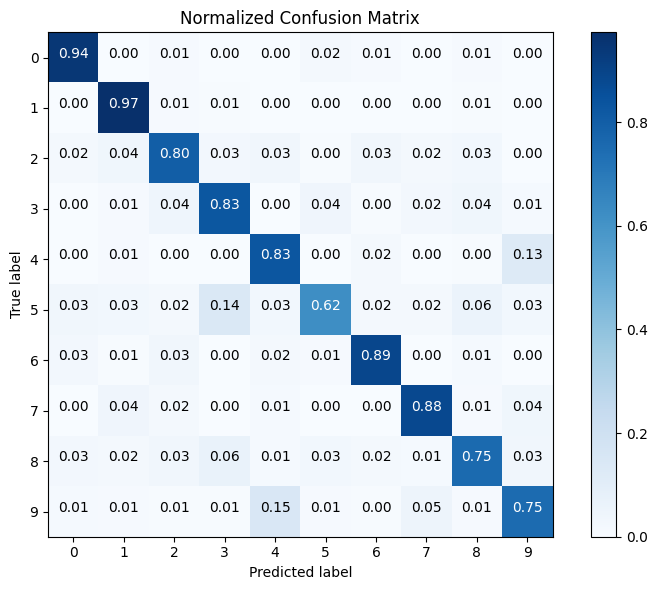


Training with RMSprop Optimizer
Epoch 1, Loss: 0.37364958815260735
Epoch 2, Loss: 0.17857978367673627
Epoch 3, Loss: 0.1328032710500109
Epoch 4, Loss: 0.10991715497351182
Epoch 5, Loss: 0.09389750718939374
Accuracy: 96.84%


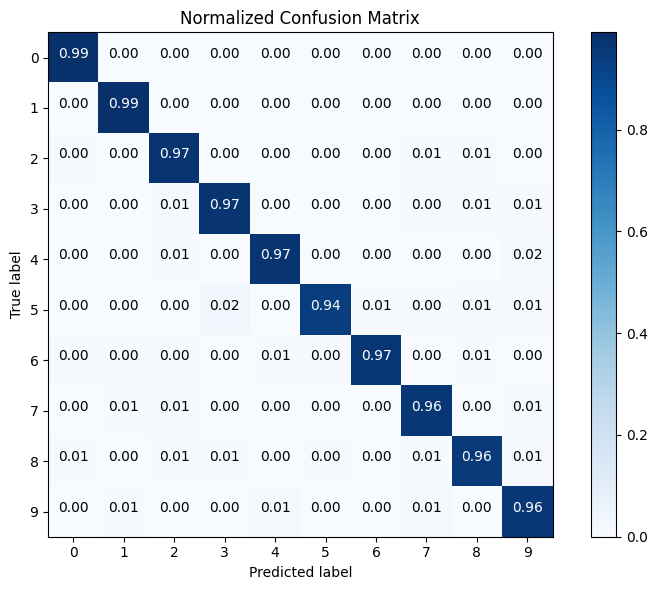


--- Optimizer Comparison ---
Adam     - Training Time: 22.11 seconds, Test Accuracy: 96.86%
SGD      - Training Time: 20.96 seconds, Test Accuracy: 83.10%
RMSprop  - Training Time: 21.97 seconds, Test Accuracy: 96.84%


In [30]:
import time

# Define a function to train the model with a specified optimizer and return training time and final accuracy
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=5):
    model.to(device)
    model.train()
    for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
    start_time = time.time()  # Start the timer for training time measurement

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

    training_time = time.time() - start_time  # Calculate the elapsed time

    # Evaluate the model on the test set
    accuracy, _ = evaluate_and_report(model, test_loader)
    
    return training_time, accuracy

# Reset the model before each training session
def reset_model():
    return SimpleDNN().to(device)

# Define loss function and learning rate
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001

# Train and evaluate using Adam optimizer
print("\nTraining with Adam Optimizer")
model = reset_model()
optimizer_adam = optim.Adam(model.parameters(), lr=learning_rate)
adam_time, adam_accuracy = train_and_evaluate(model, train_loader, test_loader, optimizer_adam, criterion, epochs=5)

# Train and evaluate using SGD optimizer
print("\nTraining with SGD Optimizer")
model = reset_model()
optimizer_sgd = optim.SGD(model.parameters(), lr=learning_rate)
sgd_time, sgd_accuracy = train_and_evaluate(model, train_loader, test_loader, optimizer_sgd, criterion, epochs=5)

# Train and evaluate using RMSprop optimizer
print("\nTraining with RMSprop Optimizer")
model = reset_model()
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=learning_rate)
rmsprop_time, rmsprop_accuracy = train_and_evaluate(model, train_loader, test_loader, optimizer_rmsprop, criterion, epochs=5)

# Summarize and compare results
print("\n--- Optimizer Comparison ---")
print(f"Adam     - Training Time: {adam_time:.2f} seconds, Test Accuracy: {adam_accuracy:.2f}%")
print(f"SGD      - Training Time: {sgd_time:.2f} seconds, Test Accuracy: {sgd_accuracy:.2f}%")
print(f"RMSprop  - Training Time: {rmsprop_time:.2f} seconds, Test Accuracy: {rmsprop_accuracy:.2f}%")


* Adam:

Training Time: Usually slower than SGD but faster than RMSprop due to its adaptive learning rate properties.
Accuracy: Often achieves the best or near-best accuracy in a limited number of epochs due to its efficient parameter updates.

* SGD:

Training Time: Generally, the fastest optimizer but can struggle with convergence or achieving high accuracy without additional techniques like momentum or learning rate scheduling.
Accuracy: May lag behind other optimizers in terms of final accuracy since it uses a constant learning rate.

* RMSprop:

Training Time: Often in between Adam and SGD due to its adaptive learning rate properties similar to Adam.
Accuracy: Typically performs better than SGD but may not always surpass Adam, especially for simple networks like the one used here.
